# Landreman and Paul QA configuration - finding a good set of modular coils

* QA configuration
* 5-field period
* Aspect ratio is 10
* Mean iota is 1.19

In [1]:
from simsopt.mhd import Vmec
from simsopt.geo import SurfaceRZFourier, CurveHelical
import matplotlib.pyplot as plt
import numpy as np 
%matplotlib widget

In [2]:
#v = Vmec('input.landreman_paul_qa_scaled')
v = Vmec('wout_landreman_paul_qa_scaled.nc')
nfp = v.boundary.nfp
surf = v.boundary

In [3]:
v.wout.nfp

2

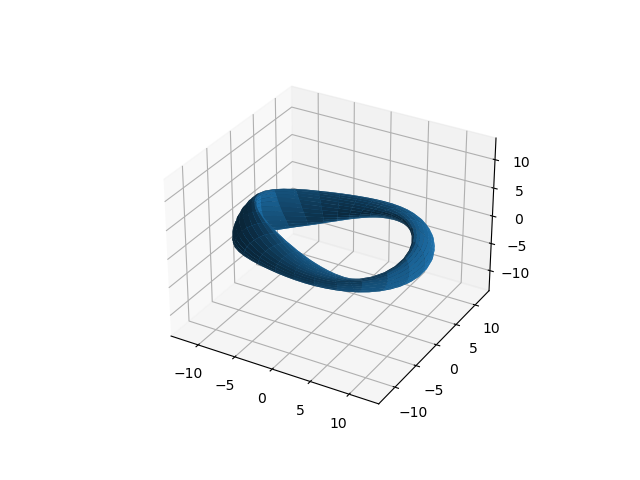

<Axes3D: >

In [4]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)

In [5]:
nfp

2

In [6]:
from simsopt.geo import CurveLength, CurveCurveDistance, MeanSquaredCurvature, LpCurveCurvature
from simsopt.geo import curves_to_vtk, create_equally_spaced_curves, CurveSurfaceDistance, ToroidalFlux
from simsopt.field.coil import apply_symmetries_to_currents, apply_symmetries_to_curves, ScaledCurrent
from simsopt.objectives import SquaredFlux, QuadraticPenalty
from simsopt.field import BiotSavart, Current
from simsopt.field.coil import Coil
from simsopt.util import MpiPartition
from scipy.optimize import minimize
from simsopt._core.optimizable import Optimizable

In [7]:
CC_dist = 0.83*1.2 # based on 83cm winding pack size + 20% margin
wcc = 1
CS_dist = 1.5 # based on blanket, structure, vessel, LT shield, gaps
wcs = 1
Length = 2*np.pi*(v.boundary.minor_radius()+CS_dist) * 1.5 # Educated guess based on minor radius of the plasma boundary
wl = 5e-4
kmax = 5.
wk = 1

tflux = -1
wtfl = 1

ncoils = 6
nwp = 0

# max curvature?
# mean curvature?
# max current?

In [8]:
base_curves = create_equally_spaced_curves( ncoils, nfp, True, R0=v.boundary.major_radius(), R1=v.boundary.minor_radius()*3, order=10 )
full_curves = apply_symmetries_to_curves( base_curves, nfp, True )

base_currents = [Current(1) for c in base_curves]
full_currents = [ScaledCurrent(c, 1e5) for c in apply_symmetries_to_currents( base_currents, nfp, True )]

# hcurve = CurveHelical( 128, 2, n0=nfp, l0=1, R0=12, r0=5 )
# hcoil = Coil( hcurve, ScaledCurrent(Current(1), 1e5) )

coils = [Coil(curve, current) for curve, current in zip(full_curves, full_currents)] #+ [hcoil]
bs = BiotSavart( coils )
bs2 = BiotSavart( coils )
bs.set_points(surf.gamma().reshape((-1,3)))

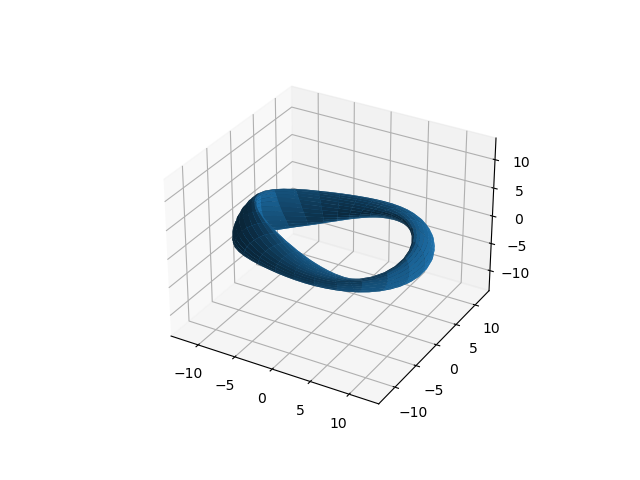

In [9]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)
for c in full_curves:
    c.plot(ax=ax, show=False)

In [10]:
for c in base_curves:
    c.fix_all()

In [11]:
sqflux = SquaredFlux( surf, bs )
torflux = QuadraticPenalty( ToroidalFlux( surf, bs2 ), tflux, 'identity' )
#lengths = QuadraticPenalty( sum([CurveLength(curve) for curve in base_curves]), Length, f='max' ) 
lengths = [QuadraticPenalty( CurveLength(curve) , Length, f='max' ) for curve in base_curves]
cc_penalty = CurveCurveDistance( full_curves, CC_dist, len(full_curves) )
cs_penalty = CurveSurfaceDistance( base_curves, surf, CS_dist )
Jcs = [LpCurveCurvature(c, 2, kmax) for c in base_curves]


JF = 1e2*sqflux + wl * np.sum(lengths) + wcc*cc_penalty + wcs*cs_penalty + wtfl * torflux + wk * np.sum(Jcs)

In [12]:
print(f'Original squared flux penalty is {sqflux.J()}')
#print(f'Max length is {Length}, starting length is {lengths.J()}')
print(f'Min coil-coil distance is {CC_dist}, starting minimum distance is {cc_penalty.shortest_distance()}')
print(f'Min plasma-coil distance is {CS_dist}, starting minimum distance is {cs_penalty.shortest_distance()}')
print(f'Original target function is {JF.J()}')

Original squared flux penalty is 0.07243528697446999
Min coil-coil distance is 0.9959999999999999, starting minimum distance is 1.2166097823502553
Min plasma-coil distance is 1.5, starting minimum distance is 1.0503084838473502
Original target function is 8.863984030237503


In [13]:
surf.fix_all()

for current in base_currents:
    current.unfix_all()
base_currents[0].fix_all()

def fun(x, info):
    JF.x = x
    info['Nfeval'] += 1
    J = JF.J()
    dJ = JF.dJ()
    if np.mod(info['Nfeval'],10)==0:
        nf = info['Nfeval']
        print(f'Evaluation #{nf}: J={J}, max(|dJ|)={np.max(np.abs(dJ))}')
    return J, dJ

In [14]:
for order in [1,2,3,4,5]:
    for curve in base_curves:
        for ii in range(0,order):
            curve.unfix(f'xc({ii})')
            curve.unfix(f'yc({ii})')
            curve.unfix(f'zc({ii})')
            if ii>0:
                curve.unfix(f'xs({ii})')
                curve.unfix(f'ys({ii})')
                curve.unfix(f'zs({ii})')
    
    options={'maxiter': 1000, 'maxcor': 300}
    dofs = JF.x
    print(f'OPTIMIZATION FOR ORDER={order}\n')
    res = minimize(fun, dofs, jac=True, method='L-BFGS-B', args=({'Nfeval':0}), options=options, tol=1e-12)
    print(res.message)
    print(f'Optimized squared flux penalty is {sqflux.J()}')
    #print(f'Max length is {Length}, optimized length is {lengths.J()}')
    print(f'Min coil-coil distance is {CC_dist}, optimized minimum distance is {cc_penalty.shortest_distance()}')
    print(f'Min plasma-coil distance is {CS_dist}, optimized minimum distance is {cs_penalty.shortest_distance()}')
    print(f'Final target function is {JF.J()}')
    print(f'============================================\n\n')

OPTIMIZATION FOR ORDER=1

Evaluation #10: J=6.246589890850312, max(|dJ|)=16.405783761195
Evaluation #20: J=0.6582457298920821, max(|dJ|)=0.07267842494520187
Evaluation #30: J=0.6320707591320716, max(|dJ|)=0.05091249258573528
Evaluation #40: J=0.617802270405699, max(|dJ|)=0.06437220866409868
Evaluation #50: J=0.6118504513823515, max(|dJ|)=0.167676892875237
Evaluation #60: J=0.6054932966964215, max(|dJ|)=0.03770521783397872
Evaluation #70: J=0.6038956715701714, max(|dJ|)=0.009293258702361258
Evaluation #80: J=0.6026229151148761, max(|dJ|)=0.03858964676315812
Evaluation #90: J=0.6003680702770792, max(|dJ|)=0.012986100622506165
Evaluation #100: J=0.5995796747361894, max(|dJ|)=0.0028134748607924025
Evaluation #110: J=0.5985067537363411, max(|dJ|)=0.0059700301679096535
Evaluation #120: J=0.5983088444105255, max(|dJ|)=0.005006913025548044
Evaluation #130: J=0.5982261585653006, max(|dJ|)=0.004985691692527646
Evaluation #140: J=0.5975584025221055, max(|dJ|)=0.008826226902223353
Evaluation #150:

In [15]:
bs.save( f"coils/bs.ncoil={ncoils}_nwp={nwp}.json") 

'{\n  "@module": "simsopt._core.json",\n  "@class": "SIMSON",\n  "@version": "0.19.0.post0+gc859dfb3.d20230815.dirty",\n  "graph": {\n    "$type": "ref",\n    "value": "BiotSavart1"\n  },\n  "simsopt_objs": {\n    "5937424704": {\n      "@module": "simsopt._core.optimizable",\n      "@class": "DOFs",\n      "@name": "5937424704",\n      "@version": "0.19.0.post0+gc859dfb3.d20230815.dirty",\n      "x": {\n        "@module": "numpy",\n        "@class": "array",\n        "dtype": "float64",\n        "data": [\n          10.980661190444799,\n          0.2270094913700062,\n          2.2433241018975725,\n          0.05714964206160248,\n          0.20067627949224648,\n          -0.13261186324342708,\n          -0.03518601276654306,\n          -0.08837109721431514,\n          0.05504919087936734,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n          0.0,\n       

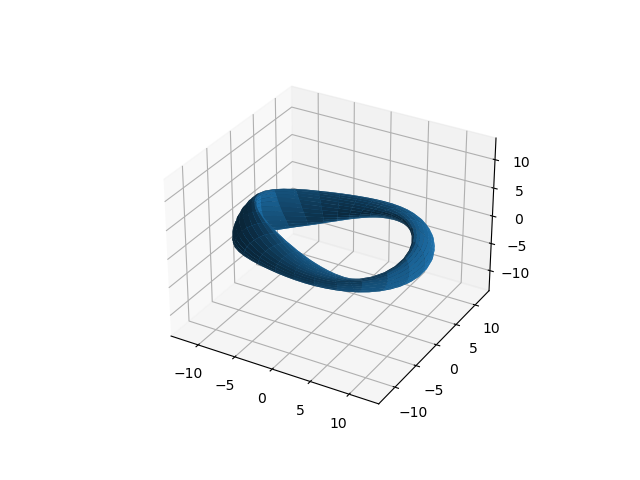

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf.plot(ax=ax, close=True)
for c in full_curves:
    c.plot(ax=ax, show=False)

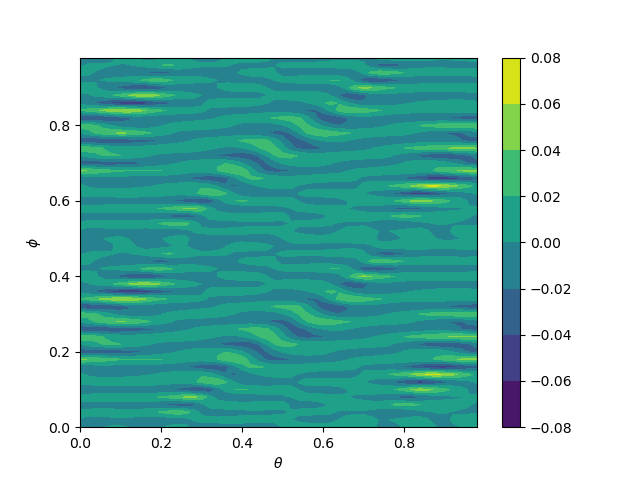

In [17]:
fig, ax = plt.subplots()
theta = surf.quadpoints_theta
phi = surf.quadpoints_phi
ntheta = theta.size
nphi = phi.size
bs.set_points(surf.gamma().reshape((-1,3)))
Bdotn = np.sum(bs.B().reshape((nphi, ntheta, 3)) * surf.unitnormal(), axis=2) / bs.AbsB().reshape((nphi,ntheta))
modb = np.mean(bs.AbsB())


#ax.set_title(f'B normal from coils {indices}')
ax.set_ylabel(r'$\phi$')
ax.set_xlabel(r'$\theta$')
c = ax.contourf(theta,phi,Bdotn/modb)
#c = ax.contourf(theta,phi,Bdotn+np.flip(np.flip(Bdotn,axis=1),axis=0))
plt.colorbar(c)

In [18]:
np.mean(bs.AbsB())

0.13993921100174203

In [19]:
from pystellplot.Paraview import coils_to_vtk, surf_to_vtk
from simsopt.field import compute_fieldlines, LevelsetStoppingCriterion, SurfaceClassifier, plot_poincare_data
import os

In [20]:
coils_to_vtk( coils, os.path.join('coils', f'coils.ncoil={ncoils}_nwp={nwp}' ) )
surf_to_vtk( os.path.join('surf', f'surf.ncoil={ncoils}_nwp={nwp}'), bs, surf )

In [21]:
vmec_surf_1 = SurfaceRZFourier.from_wout('wout_landreman_paul_qa_scaled.nc') # Expanded vmec surface
vmec_surf_1.extend_via_normal(0.1)

In [24]:
nfieldlines = 10
tmax_fl = 20000
degree = 4
Rmaj = v.boundary.major_radius()
r0 = v.boundary.minor_radius()

def trace_fieldlines(bfield):
    # Set up initial conditions - 
    R0 = np.linspace(11, 12, nfieldlines)
    Z0 = np.zeros(nfieldlines)
    phis = [(i/4)*(2*np.pi/nfp) for i in range(4)]
    fieldlines_tys, fieldlines_phi_hits = compute_fieldlines(
        bfield, R0, Z0, tmax=tmax_fl, tol=1e-8,
        phis=phis, stopping_criteria=[])

    plot_poincare_data(
        fieldlines_phi_hits, phis, 
        'poincare_fieldline.png', 
        dpi=150,surf=v.boundary,mark_lost=False
    )
    return fieldlines_phi_hits

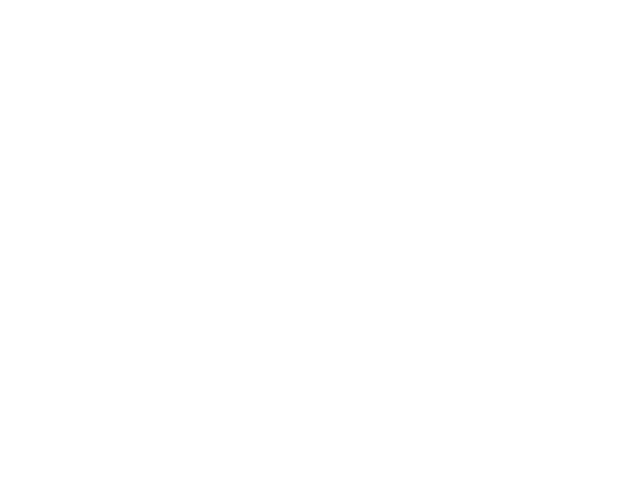

In [25]:
hits = trace_fieldlines(bs)